# Project Overview

In this project, I teach a Reinforcement Learning agent to play Space Invaders. In order to create the Space Invaders environment, I used OpenAI Gym which offers a many simulated environments such as Atari games, board games, etc. 

I used a nueral network model to process each frame of the environment, so the model knew what the agent was doing and where environment objects were. The RL agent was trained for 10,000 steps, where each step represents an action taken by the agent (ex. UP/DOWN/LEFT/RIGHT). 

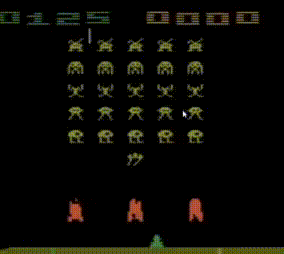

# Install Dependencies

In [1]:
!pip install tensorflow==2.3.1 gym keras-rl2 gym[atari]

# 1) Testing out the Space Invaders Environment

In [2]:
import gym
import random
import time

In [3]:
env = gym.make('SpaceInvaders-v0', render_mode='human')
height, width, channels = env.observation_space.shape
actions = env.action_space.n

Possible actions for our Agent in the Space Invaders Environment 

In [4]:
env.unwrapped.get_action_meanings()

['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']

Test Space Invaders environment with 5 epidodes (games). We will use the `random` libary to select random actions for our angent and see how it performs.

In [ ]:
episodes = 5
for episode in range(1, episodes+1):
    
    # Reset state of env for each game
    state = env.reset()
    done = False
    # Reset score of each game to 0
    score = 0 
    
    while not done:
        time.sleep(0.1)
        # pick a random action
        action = random.choice([0,1,2,3,4,5])
        n_state, reward, done, info = env.step(action)       
        score+=reward
    print('Episode:{} Score:{}'.format(episode, score))
    
env.close()

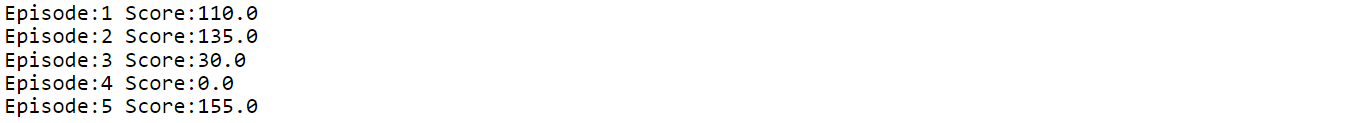

# 2) Create a Deep RL Model using Keras

In [6]:
!pip install protobuf==3.19.0

In [7]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Convolution2D
from tensorflow.keras.optimizers import Adam

import visualkeras
from PIL import ImageFont

Building model based off enviroment's dimensions and actions 

In [8]:
def build_model(height, width, channels, actions):
    model = Sequential()
    model.add(Convolution2D(32,  (8,8), strides=(4,4), activation='relu', input_shape=(3,height, width, channels)))
    model.add(Convolution2D(64, (4,4), strides=(2,2), activation='relu'))
    model.add(Convolution2D(64, (3,3), activation='relu'))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(actions, activation='linear'))
    return model

In [15]:
# delete and rebuild model if we tensor graph error occurs in dqn = build_agent(model, actions)
# del model 

In [16]:
model = build_model(height, width, channels, actions)

In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 3, 51, 39, 32)     6176      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 24, 18, 64)     32832     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 3, 22, 16, 64)     36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 67584)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               34603520  
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_6 (Dense)              (None, 6)                

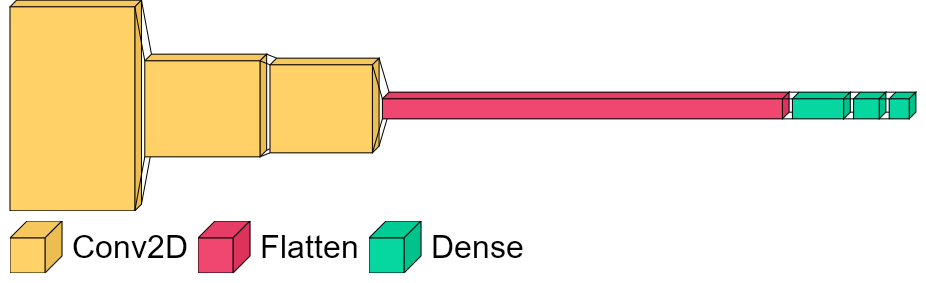

In [11]:
font = ImageFont.truetype("arial.ttf", 32) 
visualkeras.layered_view(model, legend=True, font=font)  

The neural network model I used to process frames from the enviroment is comprised of 3 convolutional2D layers and 3 dense layers. I used 32 filters which are trained to detect objects in the game such as enemies (ex. the minon ships and mother ship).  The size of filters are 8x8 and the number of filters and the number of strides. The second layer and third layer also consist of convolutional layers with a different number of filters, filter sizes, and stride size. 

I use a flatten layer to flatten all the layers into a single layer so we can pass it through a dense layer. Which transforms our inputs into a fully compressed image to just 6 actions. 

The first dense layers contains 512 units. And the second dense layer compresses  this layer slighty more to 256 units. And the third dense layer is equivalent to size of actions 6 units. 

# 3) Build our DQN Agent using Keras-RL

In [18]:
from rl.agents import DQNAgent
from rl.memory import SequentialMemory
from rl.policy import LinearAnnealedPolicy, EpsGreedyQPolicy

- `LinearAnnealedPolicy` adds decay as we approach the optimal policy 
- `EpsGreedyQPolicy` allows the agent to find the optimal reward state

In [19]:
def build_agent(model, actions):
    policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=1., value_min=.1, value_test=.2, nb_steps=10000)
    # retain memory from previous 1000 games and past 3 windows
    memory = SequentialMemory(limit=1000, window_length=3)
    dqn = DQNAgent(model=model, memory=memory, policy=policy,
                  enable_dueling_network=True, dueling_type='avg', 
                   nb_actions=actions, nb_steps_warmup=1000
                  )
    return dqn

In [20]:
dqn = build_agent(model, actions)
dqn.compile(Adam(lr=1e-4))

Train DQN agent for 10,000 steps

In [25]:
dqn.fit(env, nb_steps=10000, visualize=False, verbose=2)

Training for 10000 steps ...
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
  771/10000: episode: 1, duration: 58.726s, episode steps: 771, steps per second:  13, episode reward: 180.000, mean reward:  0.233 [ 0.000, 30.000], mean action: 2.462 [0.000, 5.000],  loss: --, mean_q: --, mean_eps: --
 1397/10000: episode: 2, duration: 339.904s, episode steps: 626, steps per second:   2, episode reward: 155.000, mean reward:  0.248 [ 0.000, 25.000], mean action: 2.463 [0.000, 5.000],  loss: 8.460996, mean_q: 0.871919, mean_eps: 0.892135
 2024/10000: episode: 3, duration: 495.509s, episode steps: 627, steps per second:   1, episode reward: 105.000, mean reward:  0.167 [ 0.000, 30.000], mean action: 2.560 [0.000, 5.000],  loss: 0.900183, mean_q: 1.178614, mean_eps: 0.846100
 2769/10000: episode: 4, duration: 598.044s, episode steps: 745, steps per second:   1, episode reward: 210.000, mean reward:  0.282 [ 0.000, 30.000], me

We can see that the agent's score for each episode becomes higher and higher, as it learns how to detect objects and develops strategies. 

#  4) Testing Model using trained DQN agent

Now that we've trained our agent for 10,000 steps. We can see our agent performs in 10 episodes (games) and collect the score from each game

In [ ]:
scores = dqn.test(env, nb_episodes=10, visualize=True)
print(np.mean(scores.history['episode_reward']))

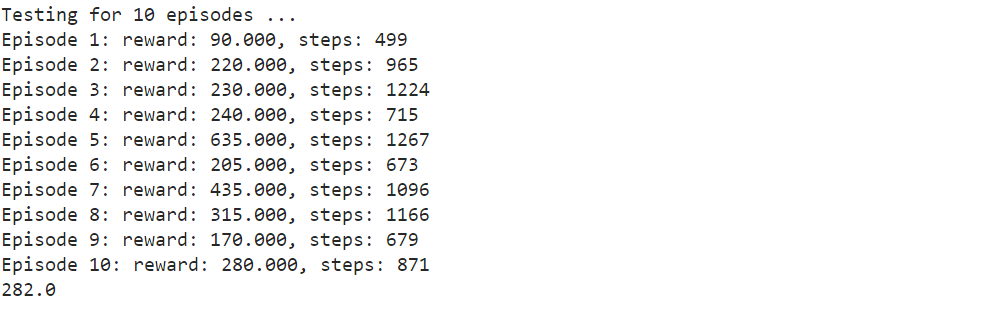

## Results and Reflection

We can see our agent does not perform too well with an average score of `282.0` after 10 games. Google reccomends training an agent for 4 million or 45 million steps. Considering we only trained the agent 10,000 steps, I still thought it was quite impressive I could the RL agent starting to develop strategies (ex.  attacking the mothership). 

# 5) Reloading Agent from Memory

In [28]:
# Saving the weights of our model trained on 10,000 steps
dqn.save_weights('SavedWeights/10k-Fast/dqn_weights.h5f')

In [36]:
del model, dqn

In [21]:
# Loading the weights of our model trained on 10,000 steps
dqn.load_weights('SavedWeights/10k-Fast/dqn_weights.h5f')